# ZNEUS - CNN on Animals 10
### Adam Glogovský, Oleksii Bieliaiev
### Our implementation of Convolutional Neural Network Image Classification using dataset Animals10 

# Imports


In [1]:
import sys
import hashlib
!{sys.executable} -m pip install torch torchvision matplotlib numpy 
from collections import Counter
import shutil
from pathlib import Path
from random import choice
from uuid import uuid4
from PIL import Image

import torch
#for faster training
torch.backends.cudnn.benchmark = True
import numpy as np
#to load the dataset and to split the dataset
from torch.utils.data import DataLoader, Subset, random_split
#for resizing of images
from torchvision import transforms


from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import wandb

from torchvision.datasets import ImageFolder
from PIL import Image
from pathlib import Path
import os
import matplotlib.pyplot as plt
import random


use_wandb = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Device: cuda


In [2]:
#simply getting working directory and appending the archive directories to it
base_dir = os.getcwd()
dataset_dir = os.path.join(base_dir, "archive/raw-img")
print("Dataset directory: ", dataset_dir)

Dataset directory:  c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive/raw-img


In [5]:
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider",
}


def rename_dirs(base_path: str):
    for fn in os.listdir(base_path):
        full = os.path.join(base_path, fn)

        if not os.path.isdir(full):
            continue
        if fn not in translate:
            continue

        new_name = translate[fn]
        print(f"{fn}  ->  {new_name}")
        os.rename(full, os.path.join(base_path, new_name))


def show_sample_images(dataset, num_images=10):
    indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img, label = dataset[idx] 
        if hasattr(img, "permute"):
            img = img.permute(1, 2, 0).numpy()

        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(dataset.classes[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Classes Count: 10

Images per class:
butterfly: 2112
cat: 1668
chicken: 3098
cow: 1866
dog: 4863
elephant: 1446
horse: 2623
sheep: 1820
spider: 4821
squirrel: 1862


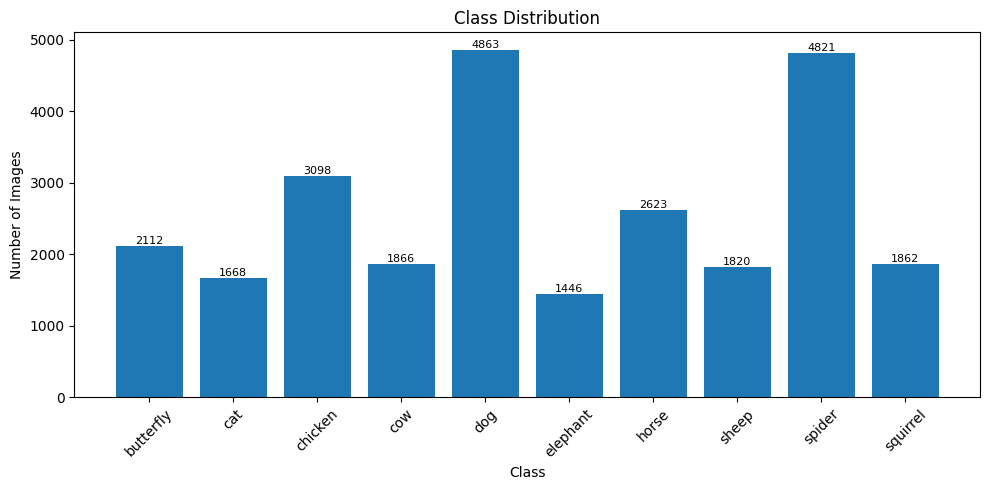

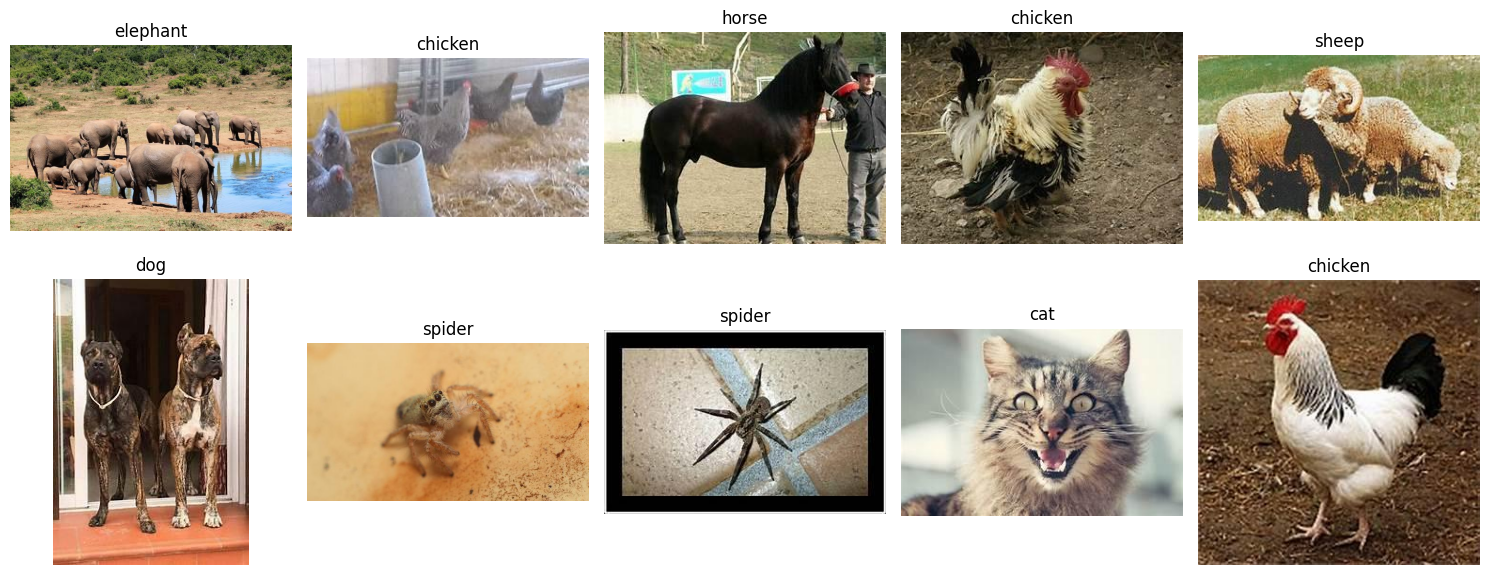

Images size statistics:
Mean width:  320.04
Mean height: 252.63
Min width:   60,  Max width:   6720
Min height:  57, Max height:  6000


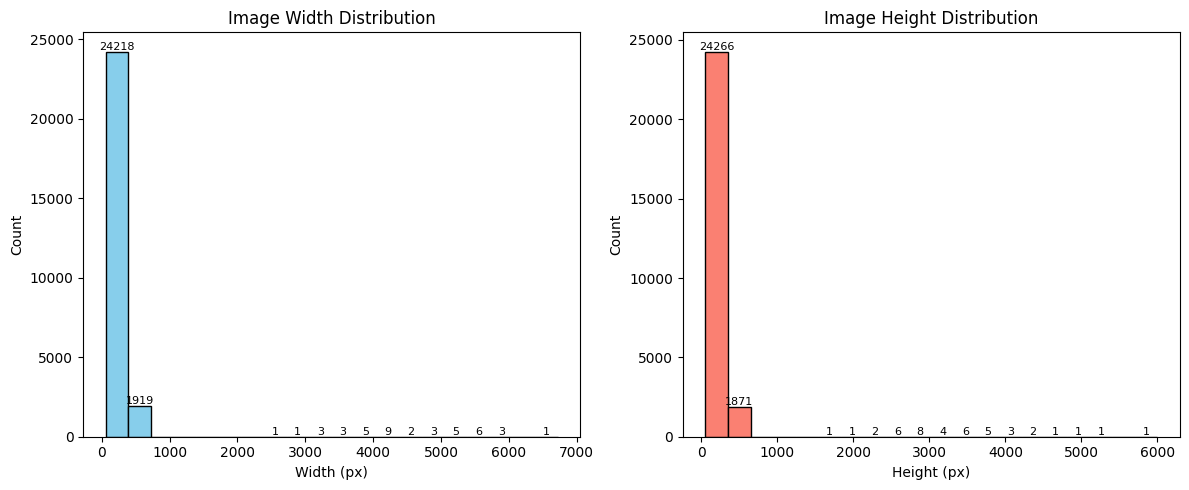

Smallest Image:
Size: 60x57
Path: c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive/raw-img\horse\OIP-4UmK-NKWl1fwEK9GfBSGKAAAAA.jpeg

Largest Image:
Size: 6720x4480
Path: c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive/raw-img\cat\max-boettinger-486490-unsplash.jpg


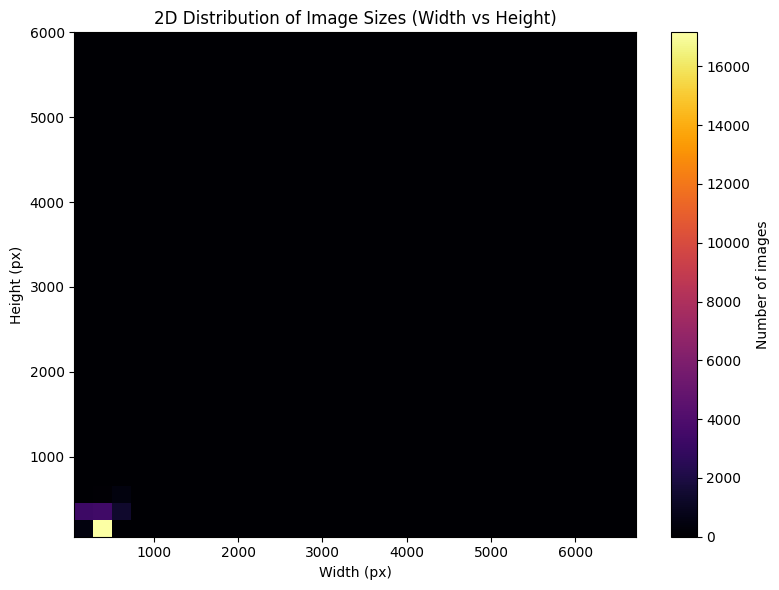

In [ ]:
# data anylisis here >
# loading dataset for data vizualization and analysis
rename_dirs(dataset_dir)

analysis_transform = transforms.ToTensor()
analysis_dataset = ImageFolder(root=dataset_dir, transform=analysis_transform)
analysis_loader = DataLoader(dataset=analysis_dataset, shuffle=True, batch_size=10)

print("Classes:", analysis_dataset.classes)
print("Classes Count:", len(analysis_dataset.classes))

counts = Counter([label for _, label in analysis_dataset.samples])

print("\nImages per class:")
for idx, cls_name in enumerate(analysis_dataset.classes):
    print(f"{cls_name}: {counts[idx]}")

plt.figure(figsize=(10, 5))
values = [counts[i] for i in range(len(analysis_dataset.classes))]
bars = plt.bar(analysis_dataset.classes, values)
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")

for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value,
        str(int(value)),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.show()

show_sample_images(analysis_dataset, num_images=10)


paths = [path for (path, _) in analysis_dataset.samples]

widths = []
heights = []

for p in paths:
    with Image.open(p) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

widths = np.array(widths)
heights = np.array(heights)

print("Images size statistics:")
print(f"Mean width:  {widths.mean():.2f}")
print(f"Mean height: {heights.mean():.2f}")
print(f"Min width:   {widths.min()},  Max width:   {widths.max()}")
print(f"Min height:  {heights.min()}, Max height:  {heights.max()}")

plt.figure(figsize=(12, 5))

# Width distribution histogram
plt.subplot(1, 2, 1)
counts_w, bins_w, patches_w = plt.hist(
    widths, bins=20, color="skyblue", edgecolor="black"
)
plt.title("Image Width Distribution")
plt.xlabel("Width (px)")
plt.ylabel("Count")

# Titles above bars
for count, patch in zip(counts_w, patches_w):
    if count > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,
            count,
            str(int(count)),
            ha="center",
            va="bottom",
            fontsize=8,
        )

# Height distribution histogram
plt.subplot(1, 2, 2)
counts_h, bins_h, patches_h = plt.hist(
    heights, bins=20, color="salmon", edgecolor="black"
)
plt.title("Image Height Distribution")
plt.xlabel("Height (px)")
plt.ylabel("Count")

for count, patch in zip(counts_h, patches_h):
    if count > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,
            count,
            str(int(count)),
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.tight_layout()
plt.show()


sizes = []

for path, _ in analysis_dataset.samples:
    with Image.open(path) as img:
        w, h = img.size
        sizes.append((w, h, path))


min_size = min(sizes, key=lambda x: x[0] * x[1])
max_size = max(sizes, key=lambda x: x[0] * x[1])

print("Smallest Image:")
print(f"Size: {min_size[0]}x{min_size[1]}")
print(f"Path: {min_size[2]}")
print()

print("Largest Image:")
print(f"Size: {max_size[0]}x{max_size[1]}")
print(f"Path: {max_size[2]}")

plt.figure(figsize=(8, 6))

plt.hist2d(widths, heights, bins=30, cmap="inferno")
plt.colorbar(label="Number of images")

plt.title("2D Distribution of Image Sizes (Width vs Height)")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")

plt.tight_layout()
plt.show()

In [7]:
# Split dataset into train, val, test folders
random.seed(42)

raw_dir = dataset_dir
base_dir = os.path.dirname(raw_dir)

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

train_ratio = 0.70
val_ratio = 0.10
test_ratio = 0.20

valid_ext = (".jpg", ".jpeg", ".png", ".bmp")

for cls_name in os.listdir(raw_dir):
    cls_path = os.path.join(raw_dir, cls_name)
    if not os.path.isdir(cls_path):
        continue

    files = [f for f in os.listdir(cls_path) if f.lower().endswith(valid_ext)]

    if not files:
        continue

    random.shuffle(files)

    n = len(files)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val

    train_files = files[:n_train]
    val_files = files[n_train : n_train + n_val]
    test_files = files[n_train + n_val :]

    train_cls_dir = os.path.join(train_dir, cls_name)
    val_cls_dir = os.path.join(val_dir, cls_name)
    test_cls_dir = os.path.join(test_dir, cls_name)

    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(val_cls_dir, exist_ok=True)
    os.makedirs(test_cls_dir, exist_ok=True)

    for fname in train_files:
        shutil.copy2(os.path.join(cls_path, fname), os.path.join(train_cls_dir, fname))

    for fname in val_files:
        shutil.copy2(os.path.join(cls_path, fname), os.path.join(val_cls_dir, fname))

    for fname in test_files:
        shutil.copy2(os.path.join(cls_path, fname), os.path.join(test_cls_dir, fname))

    print(f"{cls_name}: {n_train} train | {n_val} val | {n_test} test")

print("\nNew split complete:")
print("Train:", train_dir)
print("Val:  ", val_dir)
print("Test: ", test_dir)

butterfly: 1478 train | 211 val | 423 test
cat: 1167 train | 166 val | 335 test
chicken: 2168 train | 309 val | 621 test
cow: 1306 train | 186 val | 374 test
dog: 3404 train | 486 val | 973 test
elephant: 1012 train | 144 val | 290 test
horse: 1836 train | 262 val | 525 test
sheep: 1274 train | 182 val | 364 test
spider: 3374 train | 482 val | 965 test
squirrel: 1303 train | 186 val | 373 test

New split complete:
Train: c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive\train
Val:   c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive\val
Test:  c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive\test


In [8]:
train_root = Path(train_dir)
classes = [d for d in train_root.iterdir() if d.is_dir()]
if not classes:
    raise RuntimeError(f"No class folders found in {train_root}")

target = max(len(list(d.glob('*'))) for d in classes)
print(f"Target per class: {target}")

aug_fns = [
    lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
    lambda img: img.rotate(10, expand=True),
    lambda img: img.rotate(-10, expand=True),
    lambda img: img.transpose(Image.FLIP_LEFT_RIGHT).rotate(10, expand=True),
    lambda img: img.transpose(Image.FLIP_LEFT_RIGHT).rotate(-10, expand=True),
]

for cls in sorted(classes, key=lambda p: p.name):
    files = [f for f in cls.iterdir() if f.is_file()]
    need = target - len(files)
    print(f"{cls.name}: have {len(files)}, need {need}")
    if need <= 0:
        continue
    for _ in range(need):
        src = choice(files)
        with Image.open(src) as img:
            img = img.convert('RGB')
            aug_img = choice(aug_fns)(img)
        out_path = cls / f"{src.stem}_aug_{uuid4().hex[:6]}{src.suffix}"
        aug_img.save(out_path, quality=95)


Target per class: 3404
butterfly: have 3404, need 0
cat: have 3404, need 0
chicken: have 3404, need 0
cow: have 3404, need 0
dog: have 3404, need 0
elephant: have 3404, need 0
horse: have 3404, need 0
sheep: have 3404, need 0
spider: have 3404, need 0
squirrel: have 3404, need 0


In [9]:
train_counts = {p.name: len(list(p.glob('*'))) for p in Path(train_dir).iterdir() if p.is_dir()}
print(train_counts)
print('Total:', sum(train_counts.values()))


{'butterfly': 3404, 'cat': 3404, 'chicken': 3404, 'cow': 3404, 'dog': 3404, 'elephant': 3404, 'horse': 3404, 'sheep': 3404, 'spider': 3404, 'squirrel': 3404}
Total: 34040


In [ ]:

train_path = os.path.join(base_dir, "train")
val_path = os.path.join(base_dir, "val")
test_path = os.path.join(base_dir, "test")

preprocess_basic = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor()]
)

train_raw = ImageFolder(train_path, transform=preprocess_basic)

train_raw_loader = DataLoader(dataset=train_raw, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

pixel_sum = torch.zeros(3).to(device)
pixel_sq_sum = torch.zeros(3).to(device)
total_pixels = 0

for batch_images, _ in train_raw_loader:
    batch_images = batch_images.to(device)
    batch_size, channels, height, width = batch_images.shape
    num_pixels = batch_size * height * width
    total_pixels += num_pixels

    pixel_sum += batch_images.sum(dim=[0, 2, 3])
    pixel_sq_sum += (batch_images**2).sum(dim=[0, 2, 3])

mean = pixel_sum / total_pixels
std = torch.sqrt(pixel_sq_sum / total_pixels - mean**2)

print("Train Normalization Stats:")
print("Mean:", mean.tolist())
print("Std: ", std.tolist())

img_size = (112,122)

train_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

train_set = ImageFolder(train_path, transform=train_transforms)
val_set = ImageFolder(val_path, transform=val_transforms)
test_set = ImageFolder(test_path, transform=test_transforms)


train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)

print("\nData Preparation finished!")
print("Train samples:", len(train_set))
print("Val samples:  ", len(val_set))
print("Test samples: ", len(test_set))


Train Normalization Stats:
Mean: [0.460348516702652, 0.44597113132476807, 0.3675161302089691]
Std:  [0.29312625527381897, 0.2866876721382141, 0.2889860272407532]

Data Preparation finished!
Train samples: 34040
Val samples:   2614
Test samples:  5243


# CNN Model
### This model is inspired by VGG-NET presented in "Existing architectures of classification networks for images." on ZNEUS.
### It uses convulitional layers, keeping image size with padding=1, activation functions ReLu and max pooling. After the convolutional part of the NN we have Fully connected layers, we again use ReLu activation functions, there would be Softmax at the end, but CrossEntropyLoss loss function already includes that.
### Training is straightforward, using Adam as optimizer we train our NN.
### Validating does just simple forward pass without gradient change or backprop and returns metrics (we reuse the same function for validation part of the dataset and the test part of the dataset as well)


In [ ]:
#Convolutional Model   
#Using pytorch convolutional layers https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
#MaxPooling is used in the presentation in the VGG Net, lets use it as well https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

class AnimalMLP(torch.nn.Module):
    def __init__(self, hidden_layers, kernel_size, stride, device):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.layers = torch.nn.ModuleList()
        self.prev = 3
        self.padding = 1
        self.device = device
        self.FCL_layers = torch.nn.ModuleList()
        self.FCL_out_channels = hidden_layers[2]
        self.softmax = torch.nn.Softmax(dim=1)

        
        
        for out_channels in hidden_layers[0]:
            #adding flat padding = 1
            self.layers.append(torch.nn.Conv2d(self.prev, out_channels, self.kernel_size, self.stride, self.padding))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.Conv2d(out_channels, out_channels, self.kernel_size, self.stride, self.padding))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.MaxPool2d(2))
            
            self.prev = out_channels
            
        for out_channels in hidden_layers[1]:
            self.layers.append(torch.nn.Conv2d(self.prev, out_channels, self.kernel_size, self.stride, self.padding))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.Conv2d(out_channels, out_channels, self.kernel_size, self.stride, self.padding))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.Conv2d(out_channels, out_channels, self.kernel_size, self.stride, self.padding))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.MaxPool2d(2))
            #using this to set all layers to gpu
            self.prev = out_channels
            
        self.to(self.device)

    def prepare_FCL_layers(self, input_size):
        if len(self.FCL_layers) > 0:
            return
        #added 3 Fully Connected Layers and at the end add Softmax
        self.FCL_layers.append(torch.nn.Flatten())
        self.FCL_layers.append(torch.nn.Linear(input_size, self.FCL_out_channels[0]))
        self.FCL_layers.append(torch.nn.ReLU())
        self.FCL_layers.append(torch.nn.Linear(self.FCL_out_channels[0], self.FCL_out_channels[1]))
        self.FCL_layers.append(torch.nn.ReLU())
        self.FCL_layers.append(torch.nn.Linear(self.FCL_out_channels[1], self.FCL_out_channels[2]))
        # self.FCL_layers.append(torch.nn.Softmax(dim=1))  #since we will use CrossEntropyLoss, which includes softmax, we dont need to add it here
        #using this to set all layers to gpu
        self.to(self.device)
    
    def forward(self, input):
        #going through convolutional layers
        for layer in self.layers:
            input = layer(input)
        #since output of our convolution is: torch.Size([10, 512, 7, 7]) 
        #input for our FCL will be 512*7*7 = 25088
        ## Preparing the FCL layers with the correct input size
        self.prepare_FCL_layers(input.shape[1]*input.shape[2]*input.shape[3])
        #going through fully connected layers
        for layer in self.FCL_layers:
            input = layer(input)
        return input
    

        

def train_model(model, data_loader, optimizer, loss_function):
    # print("train loss: ")
    model.train()
    for image_tensor, labels in data_loader:
        #shape is [Batch_size, Channels, Height, Width]
        #send data to gpu
        image_tensor = image_tensor.to(device)
        labels = labels.to(device)
        
        #reset gradients, do forward pass, compute loss, do backward pass and optimize
        optimizer.zero_grad()
        output = model.forward(image_tensor)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()

#since we dont want our model to be trained on this part of dataset, we dont calculate gradients, nor use optimizer, just use loss function to determine how good the model is on unseen data
def validate_model(model, data_loader, loss_function):
    model.eval()   #to set the model to evaluation mode

    correct_predictions = 0
    
    all_losses, all_probs, all_labels = [], [], []
    
    #torch.no_grad() to disable gradient computing
    with torch.no_grad():
        for image_tensor, labels in data_loader:
            image_tensor = image_tensor.to(device)
            labels = labels.to(device)
            
            output = model.forward(image_tensor)
            loss = loss_function(output, labels)
            
            predicted_classes = output.argmax(dim=1) #pick only the predicted classes of batch size
            correct_predictions += (predicted_classes == labels).sum().item()  # this compares the predicted and real classes, counts how many are correct and itemizes it to a number
            # print("correct prediction:", correct_predictions)

            
            all_losses.append(loss.item())
            all_labels.append(labels)
            all_probs.append(model.softmax(output))
        
        all_labels = torch.cat(all_labels).cpu().numpy()   #pass labels to cpu
        all_probs = torch.cat(all_probs).cpu().numpy()
        all_predicted_classes = all_probs.argmax(axis=1)
        
        f1 = f1_score(all_labels, all_predicted_classes, average='macro')
        accuracy = (all_predicted_classes == all_labels).mean()
        average_loss = sum(all_losses) / len(all_losses)

        
        print("average loss: ", average_loss, "acurracy: ", accuracy, "F1 score:", f1)
    validation_output = {
        "av_loss": average_loss, 
        "acc": accuracy,
        "f1": f1,
        "labels": all_labels,
        "classes": all_predicted_classes
    }
    return validation_output
        
            

# Experiments
### Here we define config in which parameters of our CNN are defined
### Then Training of the CNN begins and using Wandb we log metrics of the model (these metrics are used for later "local" confusion matrix)
### We also locally save the best model, so we can later load it and do a test run

In [ ]:
# experiments part

config = [
    {"hidden_layers" : [[64, 128], [256, 256, 256], [512, 512, len(test_set.classes)]],
     "learning_rate" : 0.0001,
     "min_number_of_epochs": 30
     },
    {"hidden_layers" : [[64, 128], [256, 512, 512], [1024, 1024, len(test_set.classes)]],
     "learning_rate" : 0.00001,
     "min_number_of_epochs": 20
     },
    {"hidden_layers" : [[64, 128], [256, 512, 512], [4096, 4096, len(test_set.classes)]],
     "learning_rate" : 0.0001,
     "min_number_of_epochs": 20
     },
]

best_model_per_config = {}

for current_config in config:
    hidden_layers = current_config["hidden_layers"]
    learning_rate = current_config["learning_rate"]
    print("Starting new experiment with config:", current_config)
    #defining model
    model = AnimalMLP(hidden_layers, 3, 1, device)
    #defining which loss function and optimizer will be used for training
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_model_f1 = -torch.inf
    best_model_path = f"best_model_{hashlib.md5(str(current_config).encode()).hexdigest()}.pt"
    last_val = None
    wandb_run = None
    if use_wandb:
        wandb_run = wandb.init(
            project="animal10",
            name=f"exp_{hashlib.md5(str(current_config).encode()).hexdigest()[:6]}",
            config=current_config,
        )

    #Training
    for epoch in range(current_config["min_number_of_epochs"]):
        print("Epoch: ", epoch+1)
        train_model(model, train_loader, optimizer, loss_function)
        validation_output = validate_model(model, val_loader, loss_function)
        last_val = validation_output
        if wandb_run:
            wandb_run.log({
                "epoch": epoch + 1,
                "val_loss": validation_output["av_loss"],
                "val_acc": validation_output["acc"],
                "val_f1": validation_output["f1"],
            })
        if validation_output["f1"] > best_model_f1:
            best_model_f1 = validation_output["f1"]
            torch.save(model.state_dict(), best_model_path)

    model.load_state_dict(torch.load(best_model_path, map_location=device))
    test_output = validate_model(model, test_loader, loss_function)
    if wandb_run:
        wandb_run.log({
            "best_val_f1": best_model_f1,
            "test_loss": test_output["av_loss"],
            "test_acc": test_output["acc"],
            "test_f1": test_output["f1"],
            "test_conf_mat": wandb.plot.confusion_matrix(
                y_true=test_output["labels"],
                preds=test_output["classes"],
                class_names=test_set.classes,
            ),
        })
        wandb_run.finish()

    best_model_per_config[str(current_config)] = {
        "path": best_model_path,
        "best_f1": best_model_f1,
        "last_val_loss": None if last_val is None else last_val["av_loss"],
        "last_val_acc": None if last_val is None else last_val["acc"],
        "test_loss": test_output["av_loss"],
        "test_acc": test_output["acc"],
        "test_f1": test_output["f1"],
    }

print("Summary of configs:")
for cfg, info in best_model_per_config.items():
    print(cfg, info)


Starting new experiment with config: {'hidden_layers': [[64, 128], [256, 512, 512], [4096, 4096, 10]], 'learning_rate': 0.0001, 'min_number_of_epochs': 20}


wandb: Currently logged in as: adamglog9919 (adamglog9919-my_org_ig) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch:  1
average loss:  2.044495189631427 acurracy:  0.21499617444529456 F1 score: 0.20061313119957172
Epoch:  2
average loss:  1.7272776034143236 acurracy:  0.37413925019127775 F1 score: 0.32394596675902
Epoch:  3
average loss:  1.6406822381196198 acurracy:  0.42157612853863813 F1 score: 0.3760212062122003
Epoch:  4
average loss:  1.5112721434345953 acurracy:  0.47819433817903595 F1 score: 0.43219741408983536
Epoch:  5
average loss:  1.3080731917310644 acurracy:  0.5539403213465952 F1 score: 0.5009965736664178
Epoch:  6
average loss:  1.2802648146947224 acurracy:  0.5608263198163733 F1 score: 0.5152878239999809
Epoch:  7
average loss:  1.1705521830806025 acurracy:  0.6029074215761285 F1 score: 0.5629563736614129
Epoch:  8
average loss:  1.1353676208743342 acurracy:  0.6247130833970925 F1 score: 0.6006722366427069
Epoch:  9
average loss:  1.140286745848479 acurracy:  0.6166794185156848 F1 score: 0.5922575873829284
Epoch:  10
average loss:  1.2313839815281056 acurracy:  0.6147666411629

best_val_f1,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_acc,▁
test_f1,▁
test_loss,▁
val_acc,▁▃▄▅▆▆▇▇▇▇▇█████████
val_f1,▁▃▄▅▆▆▇▇▇▇▇█████████
val_loss,█▆▅▄▂▂▁▁▁▂▁▁▁▁▁▂▂▃▃▃
best_val_f1,0.65373
epoch,20
test_acc,0.6584


Summary of configs:
{'hidden_layers': [[64, 128], [256, 512, 512], [4096, 4096, 10]], 'learning_rate': 0.0001, 'min_number_of_epochs': 20} {'path': 'best_model_bcc616f8aa95aecef90cdff743ef101f.pt', 'best_f1': 0.6537344389657346, 'last_val_loss': 1.4257683179996632, 'last_val_acc': np.float64(0.6648814078041316), 'test_loss': 1.3668485486282493, 'test_acc': np.float64(0.6584016784283807), 'test_f1': 0.6376786262357336}


In [ ]:
#load the best model
model.load_state_dict(torch.load(best_model_path))


#Testing
testing_output = validate_model(model, test_loader, loss_function)

# Testing
### After loading the best model we simply validate it again and create new wandb run to log the test metrics and confusion matrix, later also simply printing the confusion matrix locally as plot

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


test_acc,▁
test_f1,▁
test_loss,▁
test_acc,0.6584
test_f1,0.63768
test_loss,1.36685


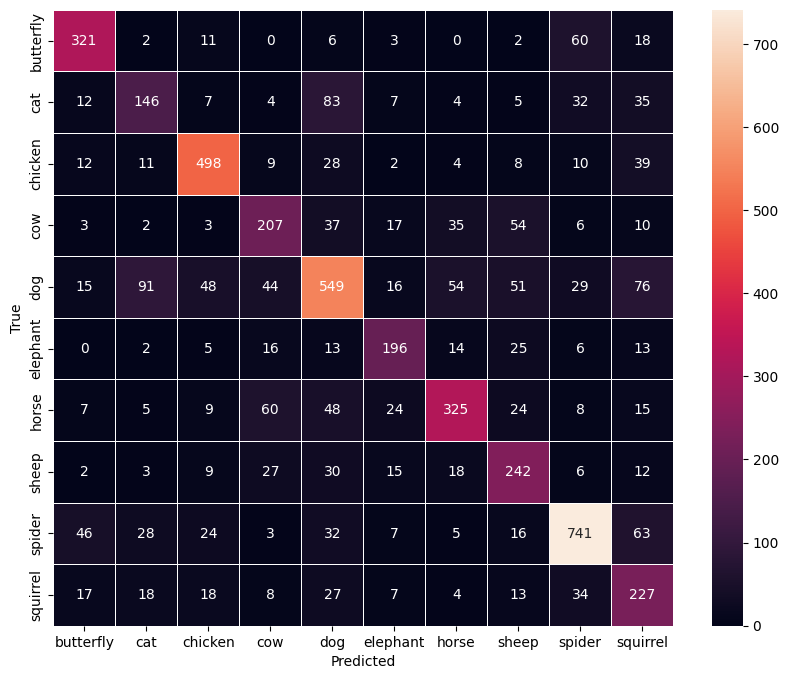

In [ ]:
#log confusion matrix of best model https://wandb.ai/wandb/plots/reports/Confusion-Matrix-Usage-and-Examples--VmlldzozMDg1NTM

if use_wandb: 
    wandb_run = wandb.init(project="animal10", reinit=True, name=f"best_model_d6f")
    wandb_run.log({
        "test_loss": testing_output["av_loss"],
        "test_acc": testing_output["acc"],
        "test_f1": testing_output["f1"],
        "conf_mat": wandb.plot.confusion_matrix(y_true=testing_output["labels"], preds=testing_output["classes"], class_names=test_set.classes),
    })
    wandb_run.finish()
    
    
plt.figure(figsize=(10,8))
confusion_mat = confusion_matrix(testing_output["labels"], testing_output["classes"], labels=list(range(len(test_set.classes)))) 
sns.heatmap(confusion_mat, annot=True, xticklabels=test_set.classes, yticklabels=test_set.classes, fmt="d", linewidths=0.5)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    
